# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [1]:
import sys
import os
from icecream import install
install()
ic.configureOutput(includeContext=True)

mt_path = os.path.abspath('/home/spacefi1/MT/MT-OpenSTL')
if mt_path not in sys.path:
    sys.path.append(mt_path)
    
pre_seq_length = 4
aft_seq_length = 4

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [24]:
from openstl.datasets.dataloader_taxibj import load_data
batch_size = 16

dataloader_train, dataloader_val, dataloader_test = \
load_data(batch_size=16,
            val_batch_size=4,
            data_root='../data/',
            num_workers=4,
            #data_name='taxibj',
            pre_seq_length=pre_seq_length, aft_seq_length=aft_seq_length,
            distributed=False, use_prefetcher=False)

In [3]:
next(iter(dataloader_train))[1].shape

torch.Size([16, 4, 2, 32, 32])

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [25]:
taxibj_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': 16,
    'val_batch_size': 16,
    'epoch': 30,
    'lr': 0.001,   
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [4, 2, 32, 32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [26]:
from openstl.api import BaseExperiment
from openstl.utils import (create_parser, default_parser, get_dist_info, load_config,
                           update_config)

args = create_parser().parse_args([])
config = args.__dict__

config = update_config(config, load_config('../configs/taxibj/FNO.py'), exclude_keys=['method']) #update_config(config, load_config('../configs/mmnist/simvp/SimVP_gSTA.py'), exclude_keys=['method'])
config = update_config(config, taxibj_training_config)
# fulfill with default values
default_values = default_parser()
ic(config)
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

ic| 1448932661.py:12 in <module>
    config: {'aft_seq_length': 4,


             'batch_size': 16,
             'ckpt_path': None,
             'clip_grad': None,
             'clip_mode': 'norm',
             'config_file': None,
             'data_root': './data',
             'dataname': 'mmnist',
             'decay_epoch': 100,
             'decay_rate': 0.1,
             'deterministic': False,
             'device': 'cuda',
             'dist': False,
             'drop': 0.0,
             'drop_last': False,
             'drop_path': 0.0,
             'epoch': 30,
             'ex_name': 'Debug',
             'filter_bias_and_bn': False,
             'final_div_factor': 10000.0,
             'fp16': False,
             'fps': False,
             'gpus': [0],
             'hidden_channels': 256,
             'in_channels': 2,
             'in_shape': [4, 2, 32, 32],
             'log_step': 1,
             'lr': 0.001,
             'lr_k_decay': 1.0,
             'method': 'FNO',
             'metric_for_bestckpt': 'val_loss',
             'met

loading config from ../configs/taxibj/FNO.py ...
overwrite config key -- ex_name: custom_exp -> Debug
overwrite config key -- dataname: custom -> mmnist



             'test': False,
             'torchscript': False,
             'total_length': 8,
             'use_augment': False,
             'use_prefetcher': False,
             'val_batch_size': 16,
             'warmup_epoch': 5,
             'warmup_lr': 1e-05,
             'weight_decay': 0.0}
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [6]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,4]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type      | Params
----------------------------------------
0 | model     | FNO_Model | 823 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.294     Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_12.2.r12.2/compiler.33191640_0
GPU 0,1,2,3: NVIDIA A100-SXM4-40GB
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.5.0+cu124
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.4
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,c

Epoch 0, global step 1278: 'val_loss' reached 0.00130 (best 0.00130), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=00-val_loss=0.001.ckpt' as top 1


Epoch 1: 100%|██████████| 1278/1278 [01:07<00:00, 18.81it/s, v_num=28, train_loss_step=0.000991, train_loss_epoch=0.00183]

Epoch 1, global step 2556: 'val_loss' reached 0.00128 (best 0.00128), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=01-val_loss=0.001.ckpt' as top 1


Epoch 2: 100%|██████████| 1278/1278 [01:07<00:00, 18.83it/s, v_num=28, train_loss_step=0.00102, train_loss_epoch=0.0019] 

Epoch 2, global step 3834: 'val_loss' reached 0.00128 (best 0.00128), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=02-val_loss=0.001.ckpt' as top 1


Epoch 3: 100%|██████████| 1278/1278 [01:07<00:00, 18.83it/s, v_num=28, train_loss_step=0.00167, train_loss_epoch=0.00189]

Epoch 3, global step 5112: 'val_loss' reached 0.00125 (best 0.00125), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=03-val_loss=0.001.ckpt' as top 1


Epoch 4: 100%|██████████| 1278/1278 [01:07<00:00, 18.83it/s, v_num=28, train_loss_step=0.00155, train_loss_epoch=0.00158]

Epoch 4, global step 6390: 'val_loss' reached 0.00107 (best 0.00107), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=04-val_loss=0.001.ckpt' as top 1


Epoch 5: 100%|██████████| 1278/1278 [01:07<00:00, 18.82it/s, v_num=28, train_loss_step=0.00102, train_loss_epoch=0.00136]

Epoch 5, global step 7668: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 1278/1278 [01:07<00:00, 18.82it/s, v_num=28, train_loss_step=0.00108, train_loss_epoch=0.00126]

Epoch 6, global step 8946: 'val_loss' reached 0.00098 (best 0.00098), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=06-val_loss=0.001.ckpt' as top 1


Epoch 7: 100%|██████████| 1278/1278 [01:07<00:00, 18.86it/s, v_num=28, train_loss_step=0.00114, train_loss_epoch=0.00118]

Epoch 7, global step 10224: 'val_loss' reached 0.00097 (best 0.00097), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=07-val_loss=0.001.ckpt' as top 1


Epoch 8: 100%|██████████| 1278/1278 [01:07<00:00, 18.82it/s, v_num=28, train_loss_step=0.000955, train_loss_epoch=0.00111]

Epoch 8, global step 11502: 'val_loss' reached 0.00088 (best 0.00088), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=08-val_loss=0.001.ckpt' as top 1


Epoch 9: 100%|██████████| 1278/1278 [01:07<00:00, 18.83it/s, v_num=28, train_loss_step=0.00134, train_loss_epoch=0.00102]

Epoch 9, global step 12780: 'val_loss' reached 0.00082 (best 0.00082), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=09-val_loss=0.001.ckpt' as top 1


Epoch 10: 100%|██████████| 1278/1278 [01:07<00:00, 18.82it/s, v_num=28, train_loss_step=0.00125, train_loss_epoch=0.000948]

Epoch 10, global step 14058: 'val_loss' reached 0.00075 (best 0.00075), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=10-val_loss=0.001.ckpt' as top 1


Epoch 11: 100%|██████████| 1278/1278 [01:07<00:00, 18.86it/s, v_num=28, train_loss_step=0.000717, train_loss_epoch=0.000901]

Epoch 11, global step 15336: 'val_loss' reached 0.00073 (best 0.00073), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=11-val_loss=0.001.ckpt' as top 1


Epoch 12: 100%|██████████| 1278/1278 [01:07<00:00, 18.84it/s, v_num=28, train_loss_step=0.00159, train_loss_epoch=0.000874]

Epoch 12, global step 16614: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 1278/1278 [01:07<00:00, 18.81it/s, v_num=28, train_loss_step=0.00131, train_loss_epoch=0.000846]

Epoch 13, global step 17892: 'val_loss' reached 0.00068 (best 0.00068), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=13-val_loss=0.001.ckpt' as top 1


Epoch 14: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000766, train_loss_epoch=0.000826]

Epoch 14, global step 19170: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 1278/1278 [01:08<00:00, 18.79it/s, v_num=28, train_loss_step=0.00053, train_loss_epoch=0.000806]

Epoch 15, global step 20448: 'val_loss' reached 0.00065 (best 0.00065), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=15-val_loss=0.001.ckpt' as top 1


Epoch 16: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000689, train_loss_epoch=0.000789]

Epoch 16, global step 21726: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000801, train_loss_epoch=0.000775]

Epoch 17, global step 23004: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000734, train_loss_epoch=0.000761]

Epoch 18, global step 24282: 'val_loss' reached 0.00064 (best 0.00064), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=18-val_loss=0.001.ckpt' as top 1


Epoch 19: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000755, train_loss_epoch=0.000749]

Epoch 19, global step 25560: 'val_loss' reached 0.00062 (best 0.00062), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=19-val_loss=0.001.ckpt' as top 1


Epoch 20: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000527, train_loss_epoch=0.00074] 

Epoch 20, global step 26838: 'val_loss' reached 0.00061 (best 0.00061), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=20-val_loss=0.001.ckpt' as top 1


Epoch 21: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000726, train_loss_epoch=0.000729]

Epoch 21, global step 28116: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 1278/1278 [01:07<00:00, 18.93it/s, v_num=28, train_loss_step=0.000851, train_loss_epoch=0.00072] 

Epoch 22, global step 29394: 'val_loss' reached 0.00060 (best 0.00060), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=22-val_loss=0.001.ckpt' as top 1


Epoch 23: 100%|██████████| 1278/1278 [01:07<00:00, 18.85it/s, v_num=28, train_loss_step=0.000573, train_loss_epoch=0.000711]

Epoch 23, global step 30672: 'val_loss' reached 0.00060 (best 0.00060), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=23-val_loss=0.001.ckpt' as top 1


Epoch 24: 100%|██████████| 1278/1278 [01:07<00:00, 18.80it/s, v_num=28, train_loss_step=0.000627, train_loss_epoch=0.000704]

Epoch 24, global step 31950: 'val_loss' reached 0.00060 (best 0.00060), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=24-val_loss=0.001.ckpt' as top 1


Epoch 25: 100%|██████████| 1278/1278 [01:07<00:00, 18.95it/s, v_num=28, train_loss_step=0.000533, train_loss_epoch=0.000699]

Epoch 25, global step 33228: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 1278/1278 [01:07<00:00, 18.94it/s, v_num=28, train_loss_step=0.00103, train_loss_epoch=0.000693]

Epoch 26, global step 34506: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 1278/1278 [01:07<00:00, 18.93it/s, v_num=28, train_loss_step=0.000721, train_loss_epoch=0.00069] 

Epoch 27, global step 35784: 'val_loss' reached 0.00059 (best 0.00059), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=27-val_loss=0.001.ckpt' as top 1


Epoch 28: 100%|██████████| 1278/1278 [01:07<00:00, 18.87it/s, v_num=28, train_loss_step=0.000641, train_loss_epoch=0.000686]

Epoch 28, global step 37062: 'val_loss' reached 0.00059 (best 0.00059), saving model to '/home/spacefi1/MT/MT-OpenSTL/examples/work_dirs/Debug/checkpoints/best-epoch=28-val_loss=0.001.ckpt' as top 1


Epoch 29: 100%|██████████| 1278/1278 [01:07<00:00, 18.82it/s, v_num=28, train_loss_step=0.000429, train_loss_epoch=0.000684]

Epoch 29, global step 38340: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1278/1278 [01:07<00:00, 18.81it/s, v_num=28, train_loss_step=0.000429, train_loss_epoch=0.000684]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,4]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 177.26it/s]


In [7]:
print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,4]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 142.47it/s]


## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

In [2]:
import numpy as np
from openstl.utils import show_video_line, show_taxibj

# show the given frames from an example
inputs = np.load('./work_dirs/Debug/saved/inputs.npy')
preds = np.load( './work_dirs/Debug/saved/preds.npy')
trues = np.load( './work_dirs/Debug/saved/trues.npy')

example_idx = 0
#show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

In [3]:
preds[example_idx].shape

(4, 2, 32, 32)

In [5]:
example_idx = 0
out = show_taxibj(preds[example_idx], out_path='./work_dirs/Debug/saved/')

ic| visualization.py:226 in show_taxibj()- 1
ic| visualization.py:231 in show_taxibj()- 2
ic| visualization.py:235 in show_taxibj()- 3
ic| visualization.py:237 in show_taxibj()- 4
ic| visualization.py:239 in show_taxibj()- 5
ic| visualization.py:241 in show_taxibj()- 6
ic| visualization.py:243 in show_taxibj()- 7
ic| visualization.py:245 in show_taxibj()- 8
ic| visualization.py:247 in show_taxibj()- 9
ic| visualization.py:250 in show_taxibj()- 10
ic| visualization.py:257 in show_taxibj()
    e: error("OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'
       ")
ic| visualization.py:262 in show_taxibj()- 'ret'


(1, 256, 256, 3)

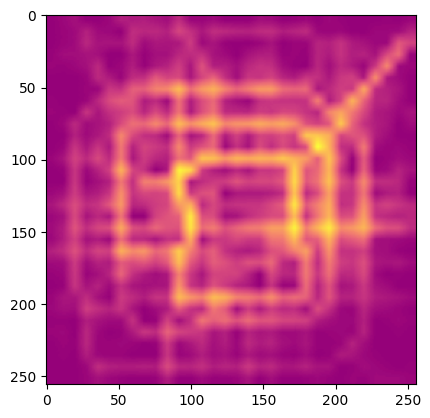

In [8]:
import matplotlib.pyplot as plt

plt.imshow(out[0])
out.shape

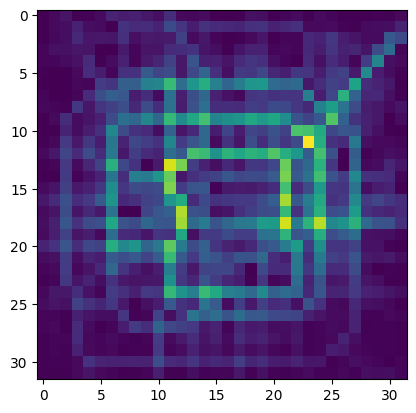

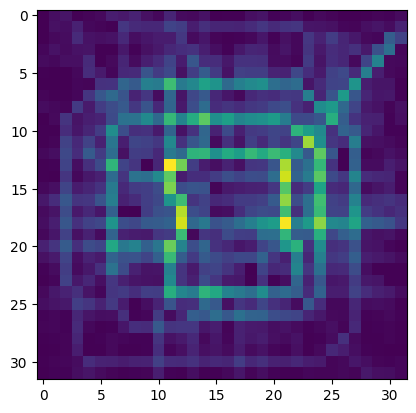

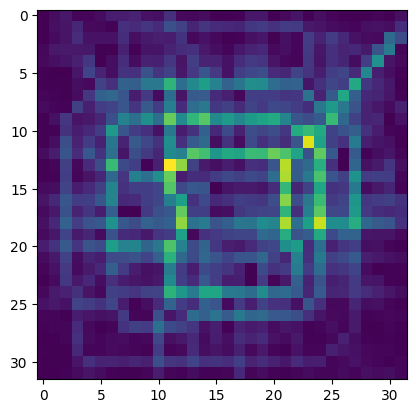

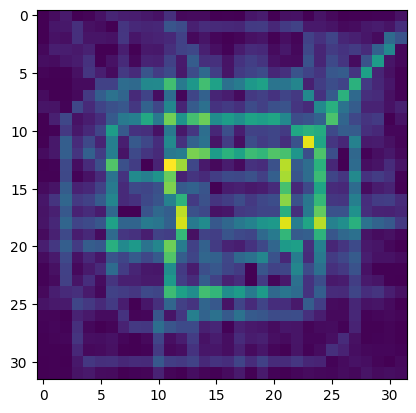

In [18]:
plt.imshow(preds[0, 0, 0])
plt.show()
plt.imshow(preds[0, 1, 0])
plt.show()
plt.imshow(preds[0, 2, 0])
plt.show()
plt.imshow(preds[0, 3, 0])
plt.show()

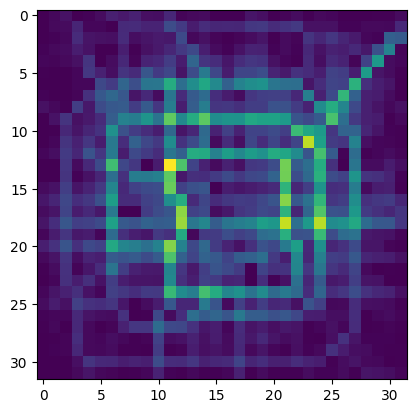

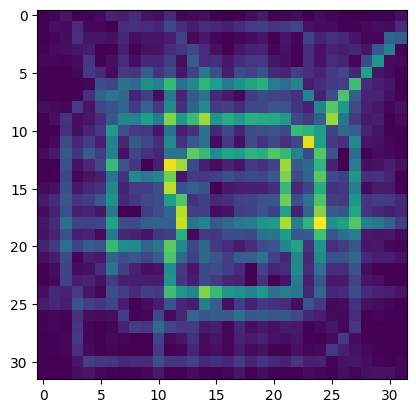

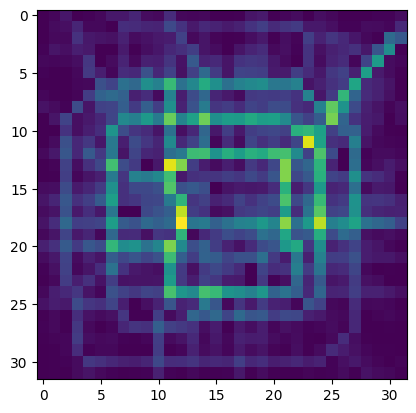

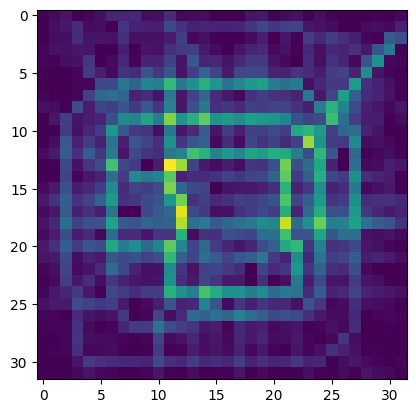

In [19]:
plt.imshow(trues[0, 0, 0])
plt.show()
plt.imshow(trues[0, 1, 0])
plt.show()
plt.imshow(trues[0, 2, 0])
plt.show()
plt.imshow(trues[0, 3, 0])
plt.show()

### 4.2 Generate a GIF

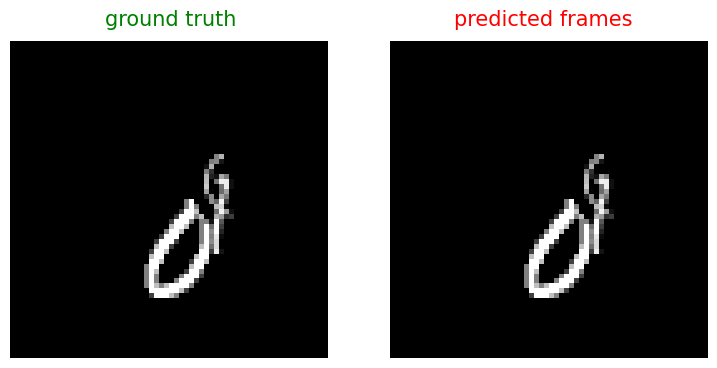

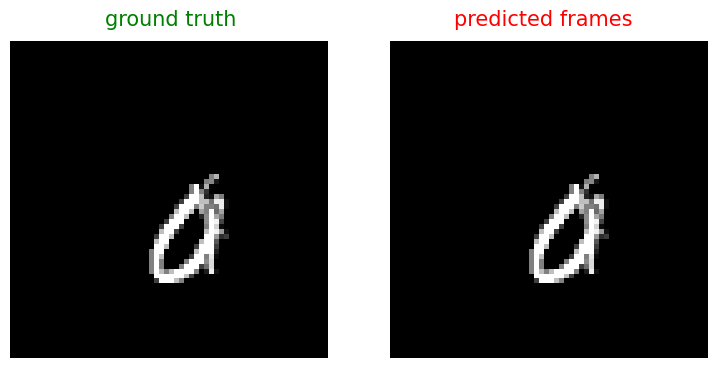

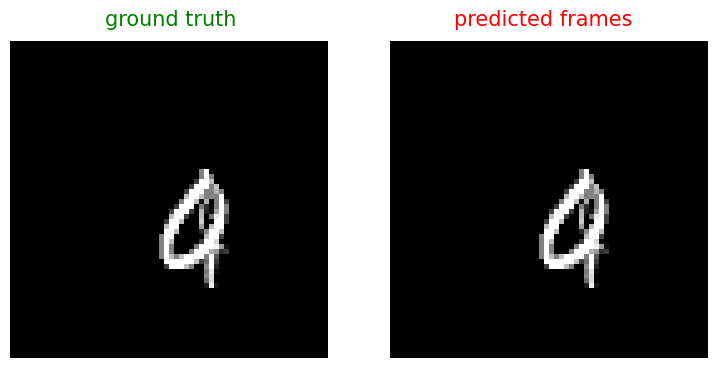

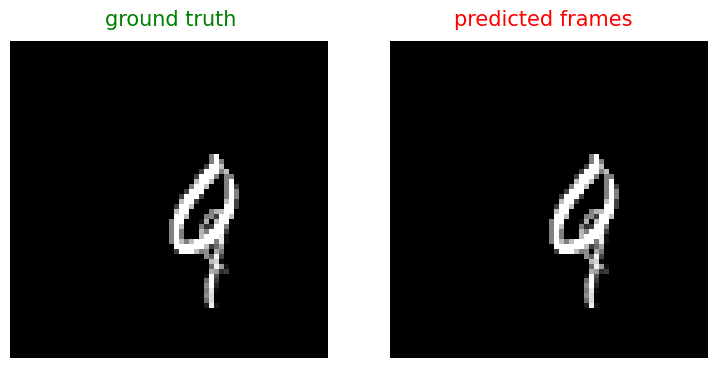

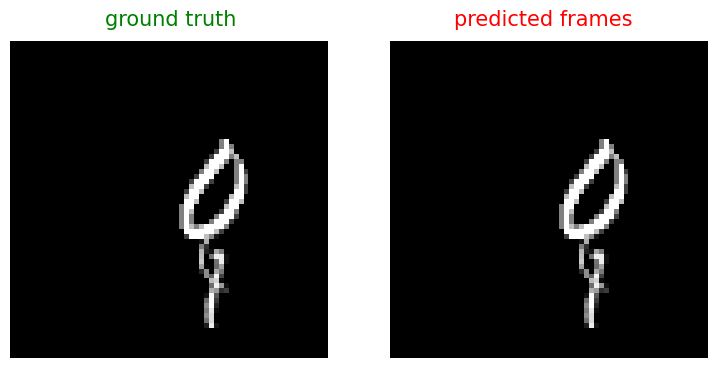

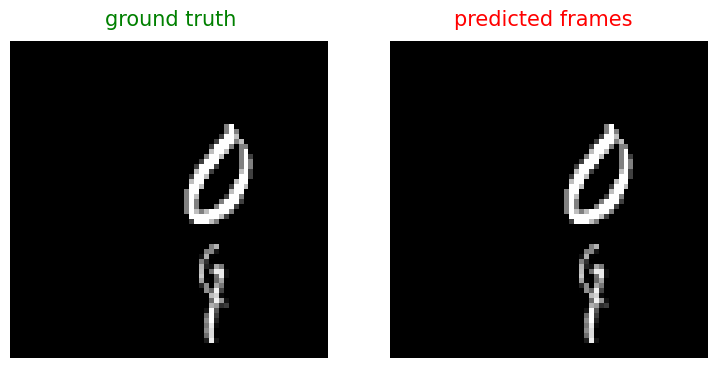

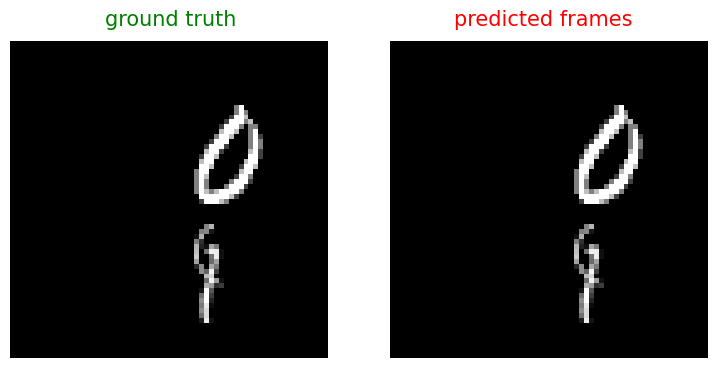

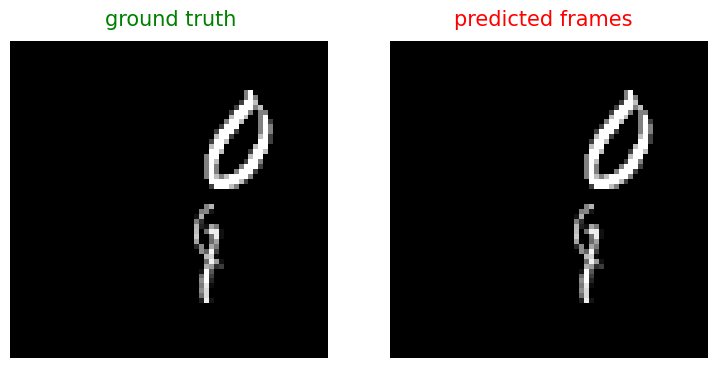

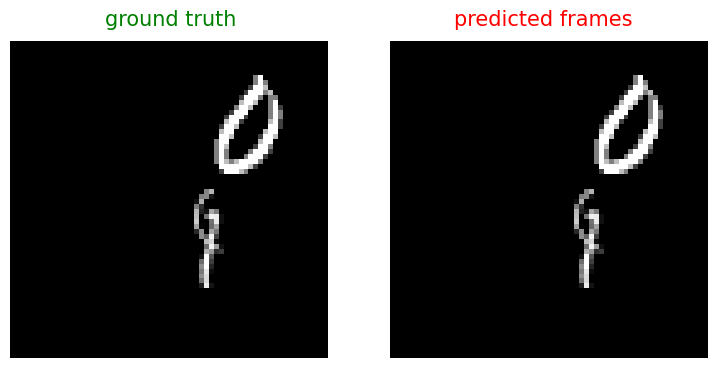

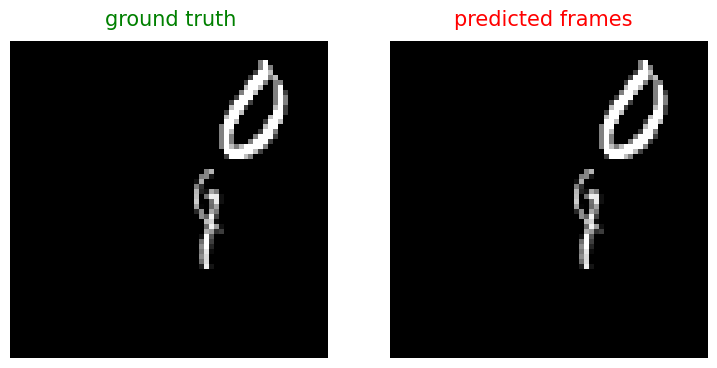

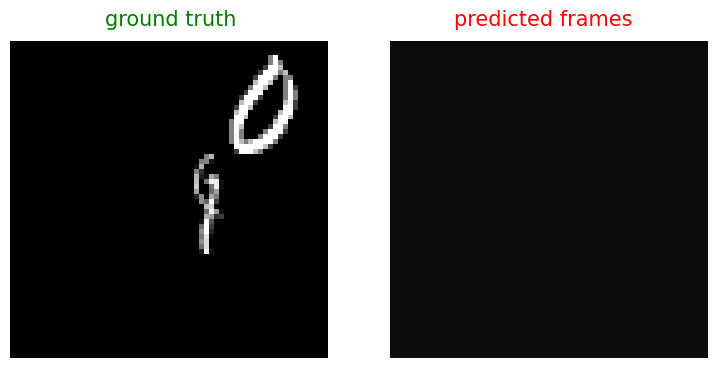

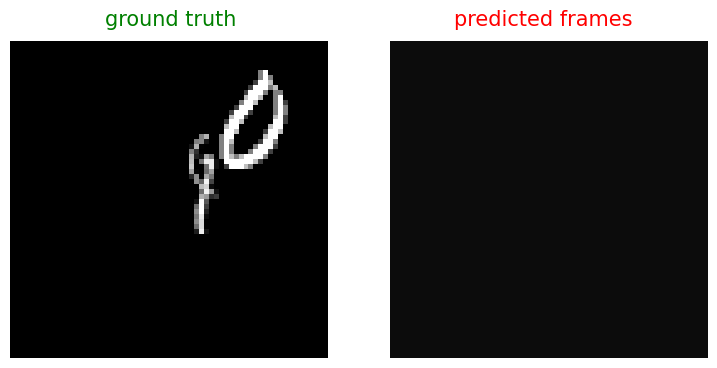

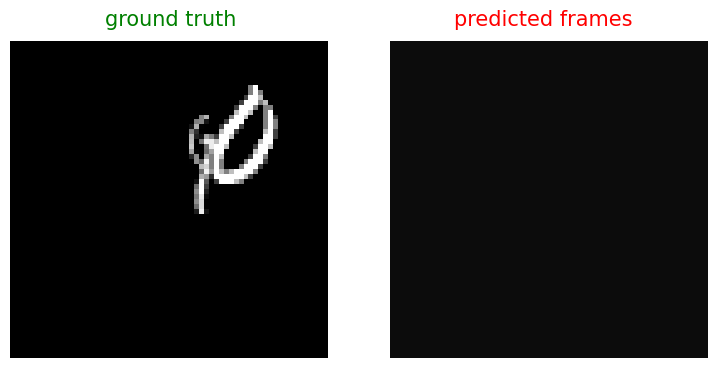

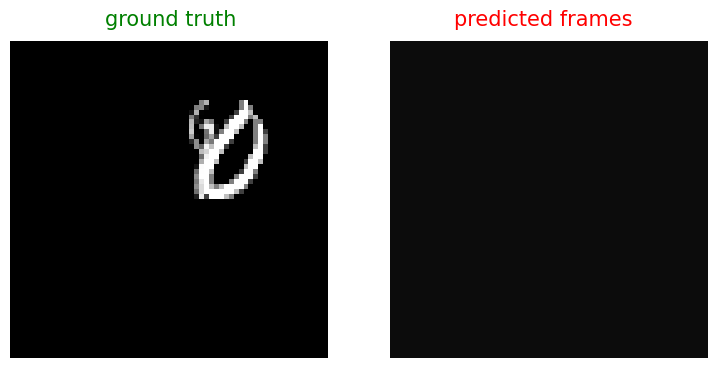

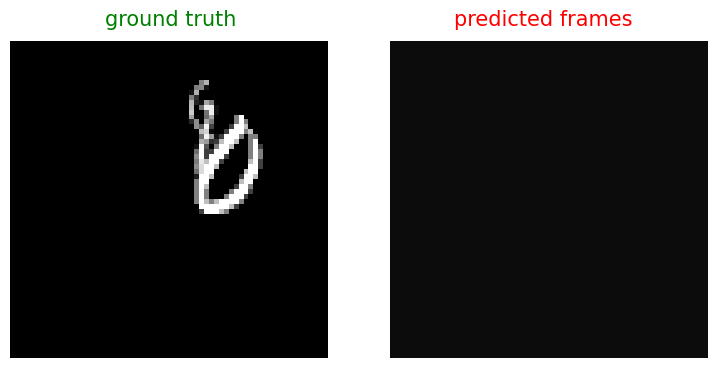

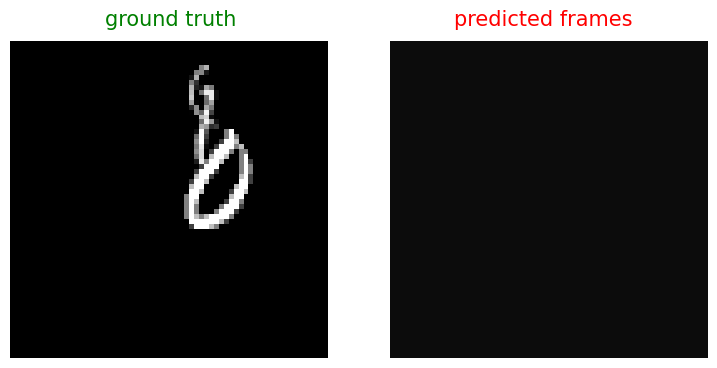

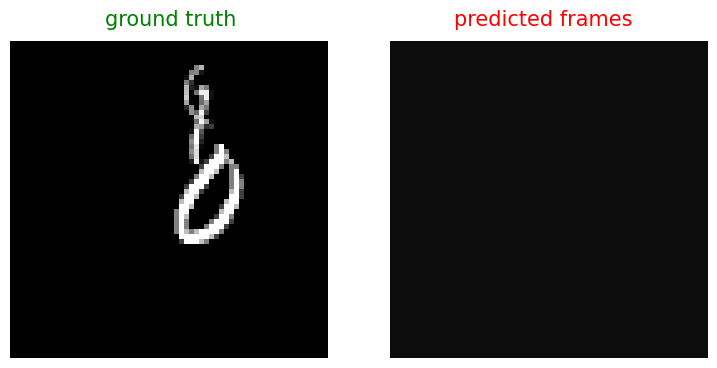

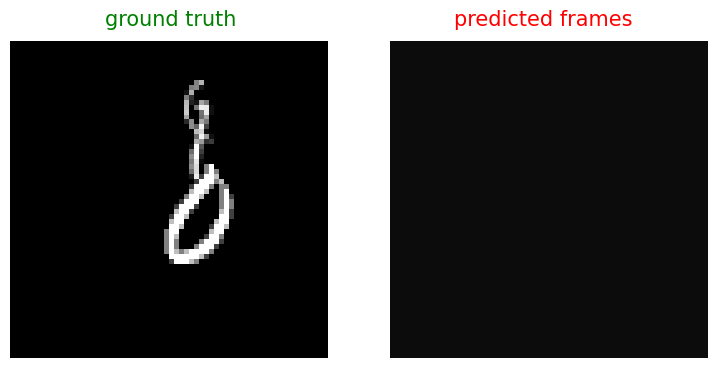

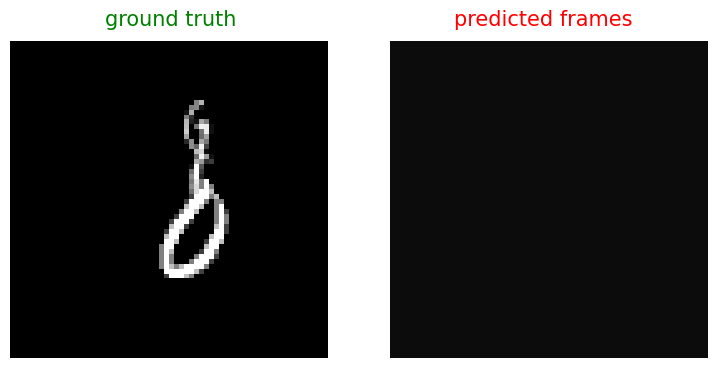

In [ ]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')